<a href="https://colab.research.google.com/github/yeoun9/torchpm/blob/main/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
! pip install git+https://github.com/yeoun9/torchpm.git
! pip install sympytorch
from torchpm import *
from torchpm.data import CSVDataset
from torchpm.estimated_parameter import *
import torch as tc
import numpy as np
import matplotlib.pyplot as plt

  Cloning https://github.com/yeoun9/torchpm.git to c:\users\sungwoo\appdata\local\temp\pip-req-build-4bmq527x
  Resolved https://github.com/yeoun9/torchpm.git to commit f0fc85b46ba8f318c41e03956238c29ba9cd5205
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/yeoun9/torchpm.git 'C:\Users\sungwoo\AppData\Local\Temp\pip-req-build-4bmq527x'


# Model Building

In [24]:
tc.set_default_dtype(tc.float32)

#TODO 주의사항 다운로드 할때 캐쉬 파일이 있으면 업데이트가 되지 않아서 이상하게 계산되는 경우가 있으니 주의해야함.
dataset_file_path = 'https://raw.githubusercontent.com/yeoun9/torchpm/main/examples/THEO.csv'
# dataset_file_path = './THEO.csv'
column_names = ['ID', 'AMT', 'TIME', 'DV', 'CMT', 'MDV', 'RATE', 'BWT']

#TODO CPU랑 GPU랑 차이남. 근데 float64나 float32를 기본으로 설정해서 똑같이 나오도록 유도
device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
# device = tc.device("cpu")
dataset = CSVDataset(dataset_file_path, column_names, device)

class BasementModel(predfunction.PredictionFunctionByTime) :
    def __init__(self, dataset: tc.utils.data.Dataset, column_names: Iterable[str], output_column_names: Iterable[str], *args, **kwargs):
        super().__init__(dataset, column_names, output_column_names, *args, **kwargs)

        self.theta_0 = Theta(1.5, 0, 10)
        self.theta_1 = Theta(32, 0, 50)
        self.theta_2 = Theta(0.08, 0, 1)

        self.eta_0 = Eta()
        self.eta_1 = Eta()
        self.eta_2 = Eta()

        self.eps_0 = Eps()
        self.eps_1 = Eps()

        self.gut_model = linearode.Comp1GutModelFunction()

        self.initialize()
    
    def _calculate_parameters(self, **para):
        k_a = self.theta_0()*tc.exp(self.eta_0())
        #TODO
        v = self.theta_1()*tc.exp(self.eta_1())#*para['BWT']/70
        k_e = self.theta_2()*tc.exp(self.eta_2())
        para['AMT'] = tc.tensor(320., device=self.dataset.device)
        return para | {"k_a": k_a, "v": v, "k_e": k_e}

    def _calculate_preds(self, t, amt, rate, **para) -> tc.Tensor:
        dose = amt
        k_a = para['k_a']
        v = para['v']
        k_e = para['k_e']
        # return (dose / v * k_a) / (k_a - k_e) * (tc.exp(-k_e*t) - tc.exp(-k_a*t))
        ############ Sympy Version Function #############
        comps = self.gut_model(t, k_a, k_e, dose)
        return comps[1]/v
        
    def _calculate_error(self, y_pred, **para) -> tc.Tensor:
        return y_pred +  y_pred * self.eps_0() + self.eps_1(), para

pred_function_module = BasementModel(dataset = dataset,
                            column_names = column_names,
                            output_column_names=['ID'],)

omega = Omega([tc.tensor([0.4397,
                        0.0575,  0.0198, 
                        -0.0069,  0.0116,  0.0205], device = device)], [False])
sigma = Sigma( [tc.tensor([0.0177, 0.0762], device = device)], [True])

model = models.FOCEInter(pred_function_module, 
                        theta_names=['0', '1', '2'],
                        eta_names=[['0', '1','2']], 
                        eps_names= [['0','1']], 
                        omega=omega, 
                        sigma=sigma)

model = model.to(device)

#Model Fitting

In [26]:
model.fit_population(learning_rate = 1, tolerance_grad = 1e-3, tolerance_change= 1e-3)

running_time :  0.5796613693237305 	 total_loss: tensor(92.1346, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  1.1721975803375244 	 total_loss: tensor(147.2339, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  1.7507688999176025 	 total_loss: tensor(92.1390, device='cuda:0', grad_fn=<AddBackward0>)


FOCEInter(
  (pred_function_module): BasementModel(
    (theta_0): Theta()
    (theta_1): Theta()
    (theta_2): Theta()
    (eta_0): Eta(
      (parameter_values): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (2): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (3): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (4): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (5): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (6): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (7): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (8): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (9): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (10): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (11): Parameter con

# Result

time-pred


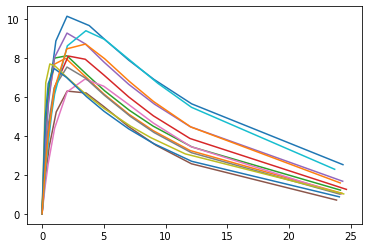

time-cwres


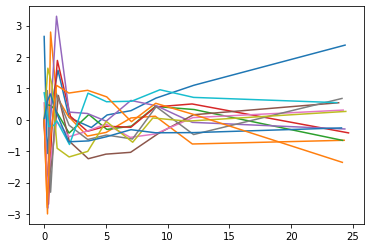

In [28]:
eval_result = model.descale().evaluate()

print('time-pred')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    y_pred = eval_result['preds'][id]
    ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu').numpy())
plt.show()

print('time-cwres')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    cwres_value = eval_result['cwress'][id]
    ax.plot(time_data.masked_select(eval_result['mdv_masks'][id]).to('cpu'), cwres_value.detach().to('cpu').numpy())
plt.show()

In [29]:
for k, v in eval_result.items():
    print(k)
    print(v)

total_loss
tensor(92.1390, device='cuda:0')
losses
{'1': 20.100858688354492, '2': 17.498111724853516, '3': -1.2991371154785156, '4': 9.29420280456543, '5': 20.167896270751953, '6': 4.121736526489258, '7': 1.2921934127807617, '8': 3.9535512924194336, '9': 2.976062774658203, '10': 4.821157455444336, '11': -2.4214344024658203, '12': 11.633766174316406}
times
{'1': tensor([ 0.0000,  0.0000,  0.2500,  0.5700,  1.1200,  2.0200,  3.8200,  5.1000,
         7.0300,  9.0500, 12.1200, 24.3700], device='cuda:0'), '2': tensor([ 0.0000,  0.0000,  0.2700,  0.5200,  1.0000,  1.9200,  3.5000,  5.0200,
         7.0300,  9.0000, 12.0000, 24.3000], device='cuda:0'), '3': tensor([ 0.0000,  0.0000,  0.2700,  0.5800,  1.0200,  2.0200,  3.6200,  5.0800,
         7.0700,  9.0000, 12.1500, 24.1700], device='cuda:0'), '4': tensor([ 0.0000,  0.0000,  0.3500,  0.6000,  1.0700,  2.1300,  3.5000,  5.0200,
         7.0200,  9.0200, 11.9800, 24.6500], device='cuda:0'), '5': tensor([ 0.0000,  0.0000,  0.3000,  0.5200, 

In [30]:
cov_result = model.descale().covariance_step()
print(cov_result)

id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
{'cov': tensor([[ 3.5381e-03,  2.6930e-02, -1.5606e-04,  1.0025e-03,  8.1969e-05,
          9.8195e-05, -2.6368e-06,  1.8273e-04,  3.3684e-04, -3.7654e-04,
          3.2088e-03],
        [ 2.6944e-02,  3.4335e-01, -1.4766e-03,  1.2936e-03, -3.4559e-03,
          1.5987e-04, -3.1178e-03,  1.3260e-03,  2.5517e-03, -1.1136e-03,
          1.0306e-02],
        [-1.5616e-04, -1.4765e-03,  7.6983e-06, -9.7937e-06,  6.8548e-06,
         -3.3033e-06,  5.0711e-06, -8.5786e-06, -1.5246e-05,  1.3997e-05,
         -1.1547e-04],
        [ 1.0110e-03,  1.3475e-03, -1.0188e-05,  2.5532e-02,  3.2457e-03,
          2.3476e-04, -3.5323e-04, -2.2658e-04, -3.5240e-04, -1.8549e-04,
         -2.5030e-03],
        [ 8.3415e-05, -3.4498e-03,  6.7970e-06,  3.2496e-03,  6.3345e-04,
          6.5053e-05,  2.1062e-04, -1.9186e-05, -6.6958e-05, -4.6387e-05,
         -1.5792e-04],
        [ 9.8598e-05,  1.6066e-04, -3.3172e-06,  2.3595e-04,  6.5213e-05,


In [31]:
for (name, para) in model.named_parameters():
    print(name)
    print(para.detach().clone().to('cpu').numpy())

pred_function_module.theta_0.parameter_value


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

#Simulation

In [22]:
tc.manual_seed(42)
simulation_result = model.simulate(dataset, 300)

for id, time_data in simulation_result['times'].items() :
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    print('id', id)
    
    p95 = np.percentile(tc.stack(simulation_result['preds'][id]).to('cpu'), 95, 0)
    p50 = np.percentile(tc.stack(simulation_result['preds'][id]).to('cpu'), 50, 0)
    average = np.average(tc.stack(simulation_result['preds'][id]).to('cpu'), 0)
    p5 = np.percentile(tc.stack(simulation_result['preds'][id]).to('cpu'), 5, 0)
    
    ax.plot(time_data.to('cpu'), p95, color="black")
    ax.plot(time_data.to('cpu'), p50, color="green")
    ax.plot(time_data.to('cpu'), average, color="red")
    ax.plot(time_data.to('cpu'), p5, color="black")
    
    for y_pred in simulation_result['preds'][id] :
        ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu'), marker='.', linestyle='', color='gray')
    plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)